In [1]:
import tensorflow as tf
%tensorflow_version 2.x
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
tf.enable_eager_execution()

In [0]:
# Loading Dataset
# we're using flowers dataset that has 5 classes

(training_set,validation_set),dataset_info = tfds.load(
    'tf_flowers',split=['train[:70%]','train[70%:]'],
    with_info=True,as_supervised=True
) 

In [4]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [5]:
# The images are not of the same size.

for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [0]:
# Resizing the images.

IMG_SIZE = 224

def format_image(image,label):
  image = tf.image.resize(image,(IMG_SIZE,IMG_SIZE)) /255.0
  return image,label

BATCH_SIZE = 32
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [0]:
# Transfer Learning 1 -  MobileNet
# Building feature extractor 

URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL,input_shape=(IMG_SIZE,IMG_SIZE,3))

In [0]:
feature_extractor.trainable = False # Freezing the model. 

In [9]:
# Attaching model with an output layer. 

model = tf.keras.Sequential([
                             feature_extractor,
                             layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
# Trainging the model. 

model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

EPOCHS=10

history = model.fit(train_batches,epochs=EPOCHS,validation_data=validation_batches)

Epoch 1/10
81/81 [==============================] - 16s 197ms/step - loss: 0.7279 - acc: 0.7314 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/10
81/81 [==============================] - 7s 87ms/step - loss: 0.3815 - acc: 0.8739 - val_loss: 0.3520 - val_acc: 0.8828
Epoch 3/10
81/81 [==============================] - 7s 84ms/step - loss: 0.2983 - acc: 0.9058 - val_loss: 0.3216 - val_acc: 0.8919
Epoch 4/10
81/81 [==============================] - 7s 84ms/step - loss: 0.2489 - acc: 0.9311 - val_loss: 0.3057 - val_acc: 0.8965
Epoch 5/10
81/81 [==============================] - 7s 84ms/step - loss: 0.2139 - acc: 0.9439 - val_loss: 0.2963 - val_acc: 0.9001
Epoch 6/10
81/81 [==============================] - 7s 85ms/step - loss: 0.1873 - acc: 0.9513 - val_loss: 0.2905 - val_acc: 0.9046
Epoch 7/10
81/81 [==============================] - 7s 86ms/step - loss: 0.1659 - acc: 0.9595 - val_loss: 0.2868 - val_acc: 0.9046
Epoch 8/10
81/81 [==============================] - 7s 84ms/step - loss: 

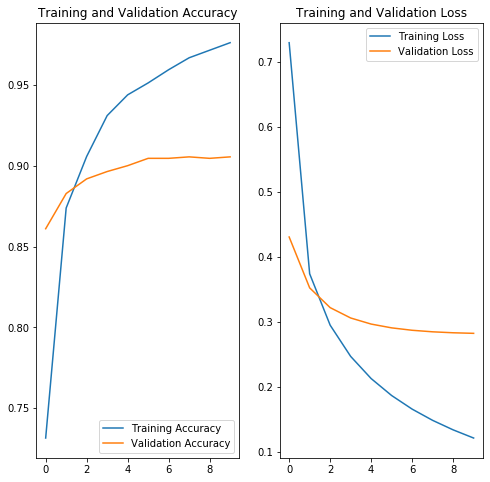

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
# Transfer Learning 2 - Inception

IMAGE_RES = 299

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)

def format_images(image,label):
  image = tf.image.resize(image,(IMAGE_RES,IMAGE_RES)) /255.0
  return image,label

train_batches = training_set.shuffle(num_training_examples//4).map(format_images).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_images).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [16]:
model_inception.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 16s 192ms/step - loss: 0.7600 - acc: 0.7264 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/6
81/81 [==============================] - 9s 117ms/step - loss: 0.4024 - acc: 0.8778 - val_loss: 0.3571 - val_acc: 0.8847
Epoch 3/6
81/81 [==============================] - 10s 118ms/step - loss: 0.3145 - acc: 0.9062 - val_loss: 0.3187 - val_acc: 0.8928
Epoch 4/6
81/81 [==============================] - 10s 120ms/step - loss: 0.2650 - acc: 0.9214 - val_loss: 0.2976 - val_acc: 0.8946
Epoch 5/6
81/81 [==============================] - 10s 118ms/step - loss: 0.2308 - acc: 0.9327 - val_loss: 0.2844 - val_acc: 0.9019
Epoch 6/6
81/81 [==============================] - 10s 118ms/step - loss: 0.2048 - acc: 0.9443 - val_loss: 0.2754 - val_acc: 0.9028


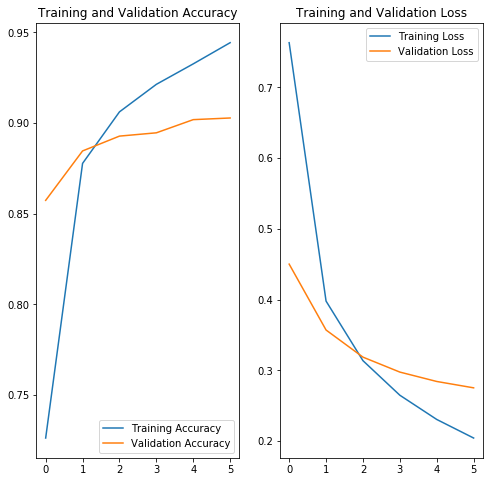

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()